In [58]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
seed=10447201

Using device: cpu


## Import dataset

In [59]:
master = pd.read_excel(r'D:/datasets/pcuk2023_ftir_whole_core/master_sheet.xlsx')
slides = master['slide'].to_numpy()
core_ids = master['core_id'].to_numpy()
patient_ids = master['patient_id'].to_numpy()
t_or_ns = master['t_or_n'].to_numpy()
pathology_infos = master['pathology_info'].to_numpy()
annotated_pixels = master['annotated_pixels'].to_numpy()
hdf5_filepaths = master['hdf5_filepath'].to_numpy()
annotation_filepaths = master['annotation_filepath'].to_numpy()
chemical_image_filepaths = master['chemical_image_filepath'].to_numpy()
mask_filepaths = master['mask_filepath'][:]
annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0],[0,255,255],[255,255,0],])#[127,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood',"crushed","immune_infiltrate"])#,
# todo dataset metrics
print(f"Loaded {len(slides)} cores")

Loaded 235 cores


## Define dataset and dataloaders

In [60]:
unique_pids = np.unique(patient_ids)
pids_trainval, pids_test, _, _ = train_test_split(unique_pids, np.zeros_like(unique_pids), test_size=0.2, random_state=seed)
pids_train, pids_val, _, _ = train_test_split(pids_trainval, np.zeros_like(pids_trainval), test_size=0.25, random_state=seed)
where_train = np.where(np.isin(patient_ids,pids_train))[0]
where_val = np.where(np.isin(patient_ids,pids_val))[0]
where_test = np.where(np.isin(patient_ids,pids_test))[0]

for name,w in zip(["train","val","test"],[where_train,where_val,where_test]):
    print(f"Using {len(w)} cores for {name} dataset")

Using 138 cores for train dataset
Using 49 cores for val dataset
Using 48 cores for test dataset


In [71]:
class chemical_image_dataset(torch.utils.data.Dataset):
    def __init__(self, patch_paths, annotations):
        self.filepaths = patch_paths
        self.annotations = annotations
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomVerticalFlip(p=0.5),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
        ])

    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        core = torch.Tensor(cv2.imread(self.filepaths[idx])[:,:,1]).unsqueeze(0) / 255
        annotations = cv2.imread(self.annotations[idx])[:,:,::-1]
        annotation_mask = np.zeros((*annotations.shape[:-1],len(annotation_class_names)))
        for tissue_class in range(len(annotation_class_names)):
            annotation_mask[:,:,tissue_class] = np.all(annotations == annotation_class_colors[tissue_class].reshape(1,1,-1),axis=-1)
        annotation_mask = torch.Tensor(annotation_mask).permute(2,0,1)
        
        return core,annotation_mask

batch_size=4
dataset_train = chemical_image_dataset(chemical_image_filepaths[where_train], annotation_filepaths[where_train])
dataset_val = chemical_image_dataset(chemical_image_filepaths[where_val], annotation_filepaths[where_val])
dataset_test = chemical_image_dataset(chemical_image_filepaths[where_test], annotation_filepaths[where_test])
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=False)
print(f"loader sizes:\n\ttrain: {len(train_loader)}\n\tval: {len(val_loader)}\n\ttest: {len(test_loader)}")

loader sizes:
	train: 35
	val: 13
	test: 12


## Define network

In [72]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            #nn.Dropout(p=0.5, inplace=False),
            nn.ReLU(inplace=True),
            #nn.Softplus(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            #nn.Softplus(),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=False):
        super(UNet, self).__init__()
        
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.softmax(self.outc(x))
        return logits
    
def sparse_loss(activations, annotations):
    # in dim: B x C x W x H
    small = 1e-12
    
    # For every annotated pixel, get the negative log of the activation for that class
    # if activation = 1, loss = -log(1) = 0
    # if activation = 0, loss = -log(0) = inf
    pixel_losses = annotations * -1 * torch.log(activations + small)

    # Sum losses over every pixel in the batch, divide by number of pixels
    # This yields the mean loss per annotated pixel
    pixel_losses = pixel_losses.sum(dim=(0,1,2,3)) / annotations.sum(dim=(0,1,2,3))
    return pixel_losses

In [73]:
model = UNet(n_channels=1,n_classes=8); model = model.to(device)
loss_fn = sparse_loss
lr = 1e-5
l2 = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=l2)

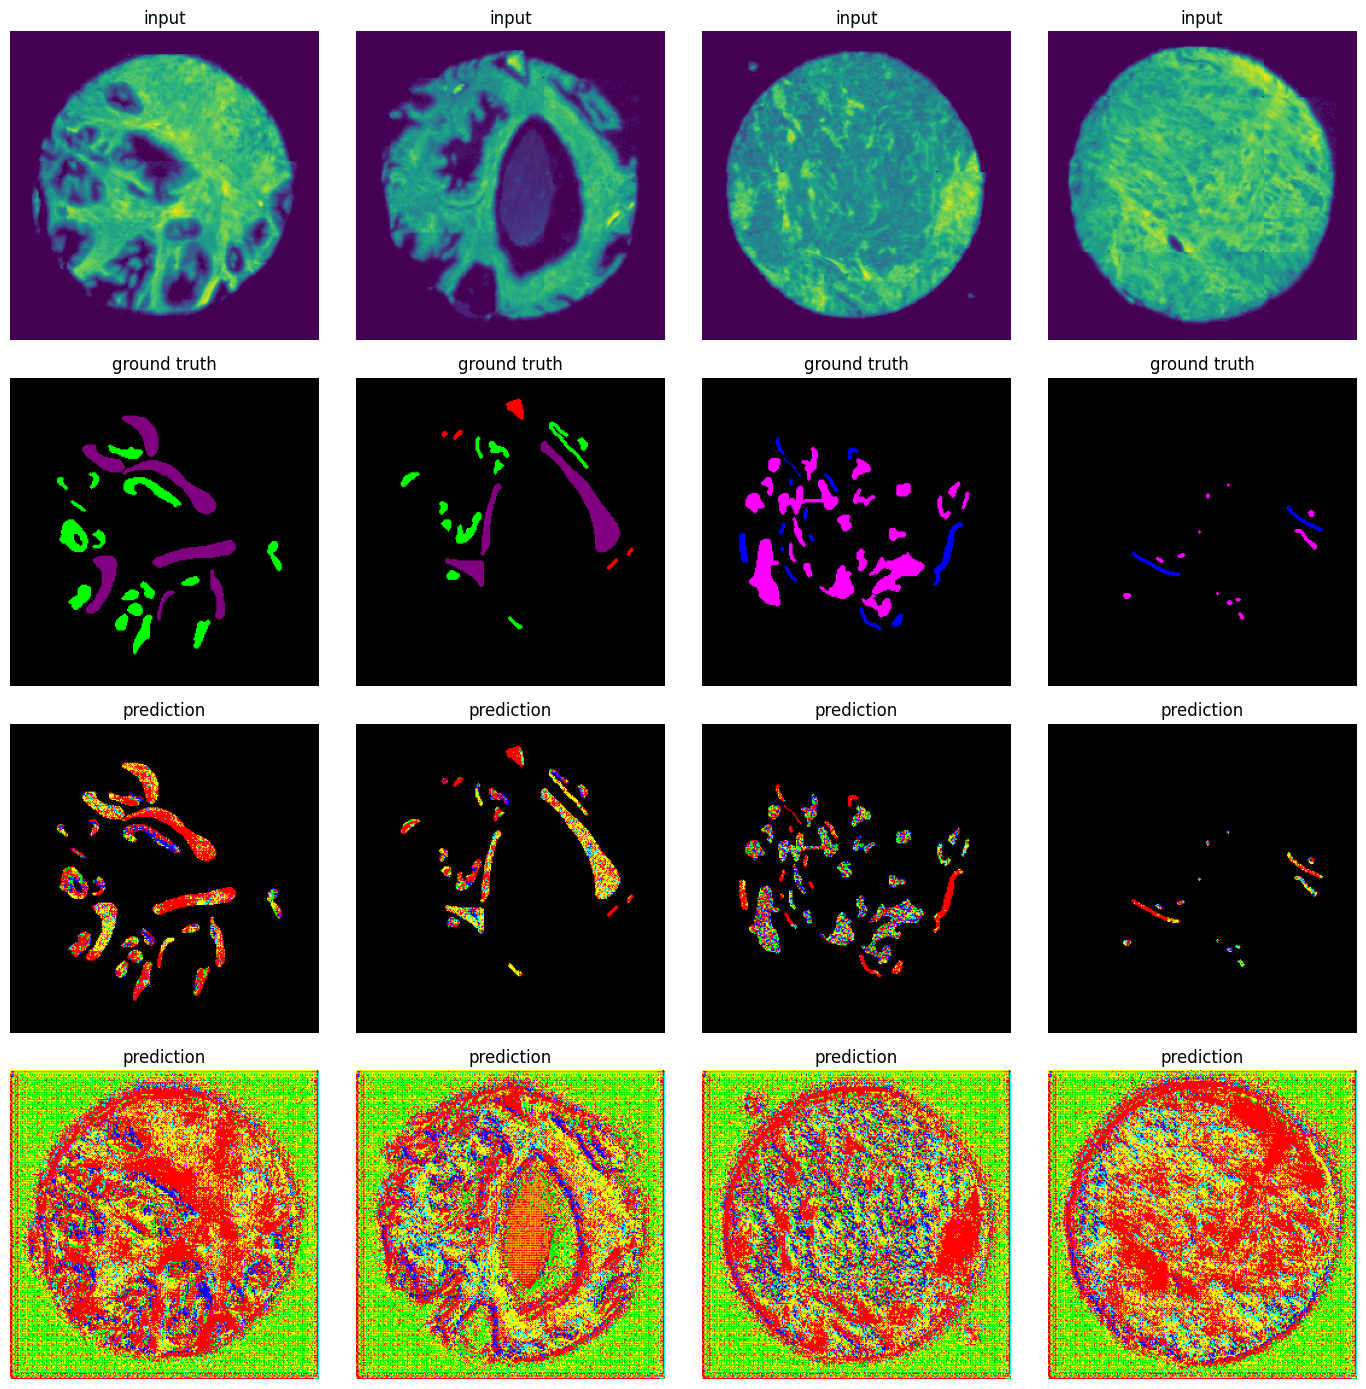

In [75]:
data,annotations = next(iter(train_loader))
out = model(data.to(device)).detach().cpu().numpy() 

mask = annotations.sum(dim=1)!=0
annotmask = annotation_class_colors[annotations.argmax(axis=1)]
predmask = annotation_class_colors[out.argmax(axis=1)]
predmask2 = predmask.copy()
annotmask[mask==0] = 0; predmask[mask==0] = 0

fig,ax = plt.subplots(4,batch_size,figsize=(14,14))
for x in range(batch_size):
    ax[0,x].imshow(data[x,0,:,:].cpu().numpy()); ax[0,x].set_axis_off(); ax[0,x].set_title("input")
    ax[1,x].imshow(annotmask[x]/255); ax[1,x].set_axis_off(); ax[1,x].set_title("ground truth")
    ax[2,x].imshow(predmask[x]/255); ax[2,x].set_axis_off(); ax[2,x].set_title("prediction")
    ax[3,x].imshow(predmask2[x]/255); ax[3,x].set_axis_off(); ax[3,x].set_title("prediction")
fig.tight_layout()
# todo save fig

## Training loop

In [77]:
training_losses,validation_losses = [],[]
#training_accs,validation_accs = [],[]
#training_f1ms,validation_f1ms = [],[]
#training_f1s,validation_f1s = [],[]
lr_decreases = []

In [78]:
for epoch in range(10):
    print(f"\n ♥ ♥ ♥ EPOCH {epoch+1} ♥ ♥ ♥")
    running_loss_train, running_loss_val = 0, 0
    train_preds,train_targets = [],[]
    val_preds,val_targets = [],[]
    
    # Train
    model.train()
    batch_frac = 42 / (len(train_loader))
    for batch_idx, (data, label) in enumerate(train_loader):
        print(f"train : {'█'*int(batch_idx*batch_frac)}", end="\r")
        data = data.to(device); label = label.to(device); #todo
        
        # Push through model and backprop
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        running_loss_train += loss.cpu().item()
        """pred = out.argmax(dim=1).detach().cpu().numpy()
        actual = label.argmax(dim=1).cpu().numpy()
        train_preds.extend(pred); train_targets.extend(actual)"""
    print(f"train : {'█'*42}")
    # Validate
    model.eval()
    batch_frac = 42 / len(val_loader)
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            print(f"val   : {'█'*int(batch_idx*batch_frac)}", end="\r")
            data = data.to(device); label = label.to(device); 
        
            # Push through model
            out = model(data)
            loss = loss_fn(out, label)
            
            # Calculate metrics
            running_loss_val += loss.cpu().item()
            """pred = out.argmax(dim=1).detach().cpu().numpy()
            actual = label.argmax(dim=1).cpu().numpy()
            val_preds.extend(pred); val_targets.extend(actual)"""
            
    """train_acc = accuracy_score(train_targets, train_preds); training_accs.append(train_acc)
    train_f1m = f1_score(train_targets, train_preds, average='macro'); training_f1ms.append(train_f1m)
    train_f1 = f1_score(train_targets, train_preds, average=None); training_f1s.append(train_f1)"""
    train_loss = running_loss_train / len(dataset_train); training_losses.append(train_loss)
    
    """val_acc = accuracy_score(val_targets, val_preds); validation_accs.append(val_acc)
    val_f1m = f1_score(val_targets, val_preds, average='macro'); validation_f1ms.append(val_f1m)
    val_f1 = f1_score(val_targets, val_preds, average=None); validation_f1s.append(val_f1)"""
    val_loss = running_loss_val / len(dataset_val); validation_losses.append(val_loss)
    print(f"val   : {'█'*42}")
    #print(f"TRAIN --- | Loss: {train_loss:.4f} | OA: {train_acc:.4f} | f1: {train_f1m:.4f}")
    print(f"TRAIN --- | Loss: {train_loss:.4f}")
    #print(f"VAL ----- | Loss: {val_loss:.4f} | OA: {val_acc:.4f} | f1: {val_f1m:.4f}")
    print(f"VAL ----- | Loss: {val_loss:.4f}")


 ♥ ♥ ♥ EPOCH 1 ♥ ♥ ♥
train : ██████████████████████████████████████████
val   : ██████████████████████████████████████████
TRAIN --- | Loss: 0.4498
VAL ----- | Loss: 0.4292

 ♥ ♥ ♥ EPOCH 2 ♥ ♥ ♥
train : ██████████████████████████████████████████
val   : ██████████████████████████████████████████
TRAIN --- | Loss: 0.3911
VAL ----- | Loss: 0.3854

 ♥ ♥ ♥ EPOCH 3 ♥ ♥ ♥


KeyboardInterrupt: 

## evaluate

In [ ]:
# Test
running_loss_test = 0
test_preds, test_targets = [], []
model.eval()
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        data = data.to(device);
        label = label.to(device);

        # Push through model
        out = model(data)
        loss = loss_fn(out, label)

        # Calculate metrics
        running_loss_test += loss.cpu().item()
        pred = out.argmax(dim=1).detach().cpu().numpy()
        actual = label.argmax(dim=1).cpu().numpy()
        test_preds.extend(pred);
        test_targets.extend(actual)

test_acc = accuracy_score(test_targets, test_preds)
test_f1m = f1_score(test_targets, test_preds, average='macro')
test_f1 = f1_score(test_targets, test_preds, average=None)
test_loss = running_loss_test / len(dataset_test)

print(f"TEST ---- | Loss: {test_loss:.4f} | OA: {test_acc:.4f} | f1: {test_f1m:.4f}")
for cls_idx, f1 in enumerate(test_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4f}")

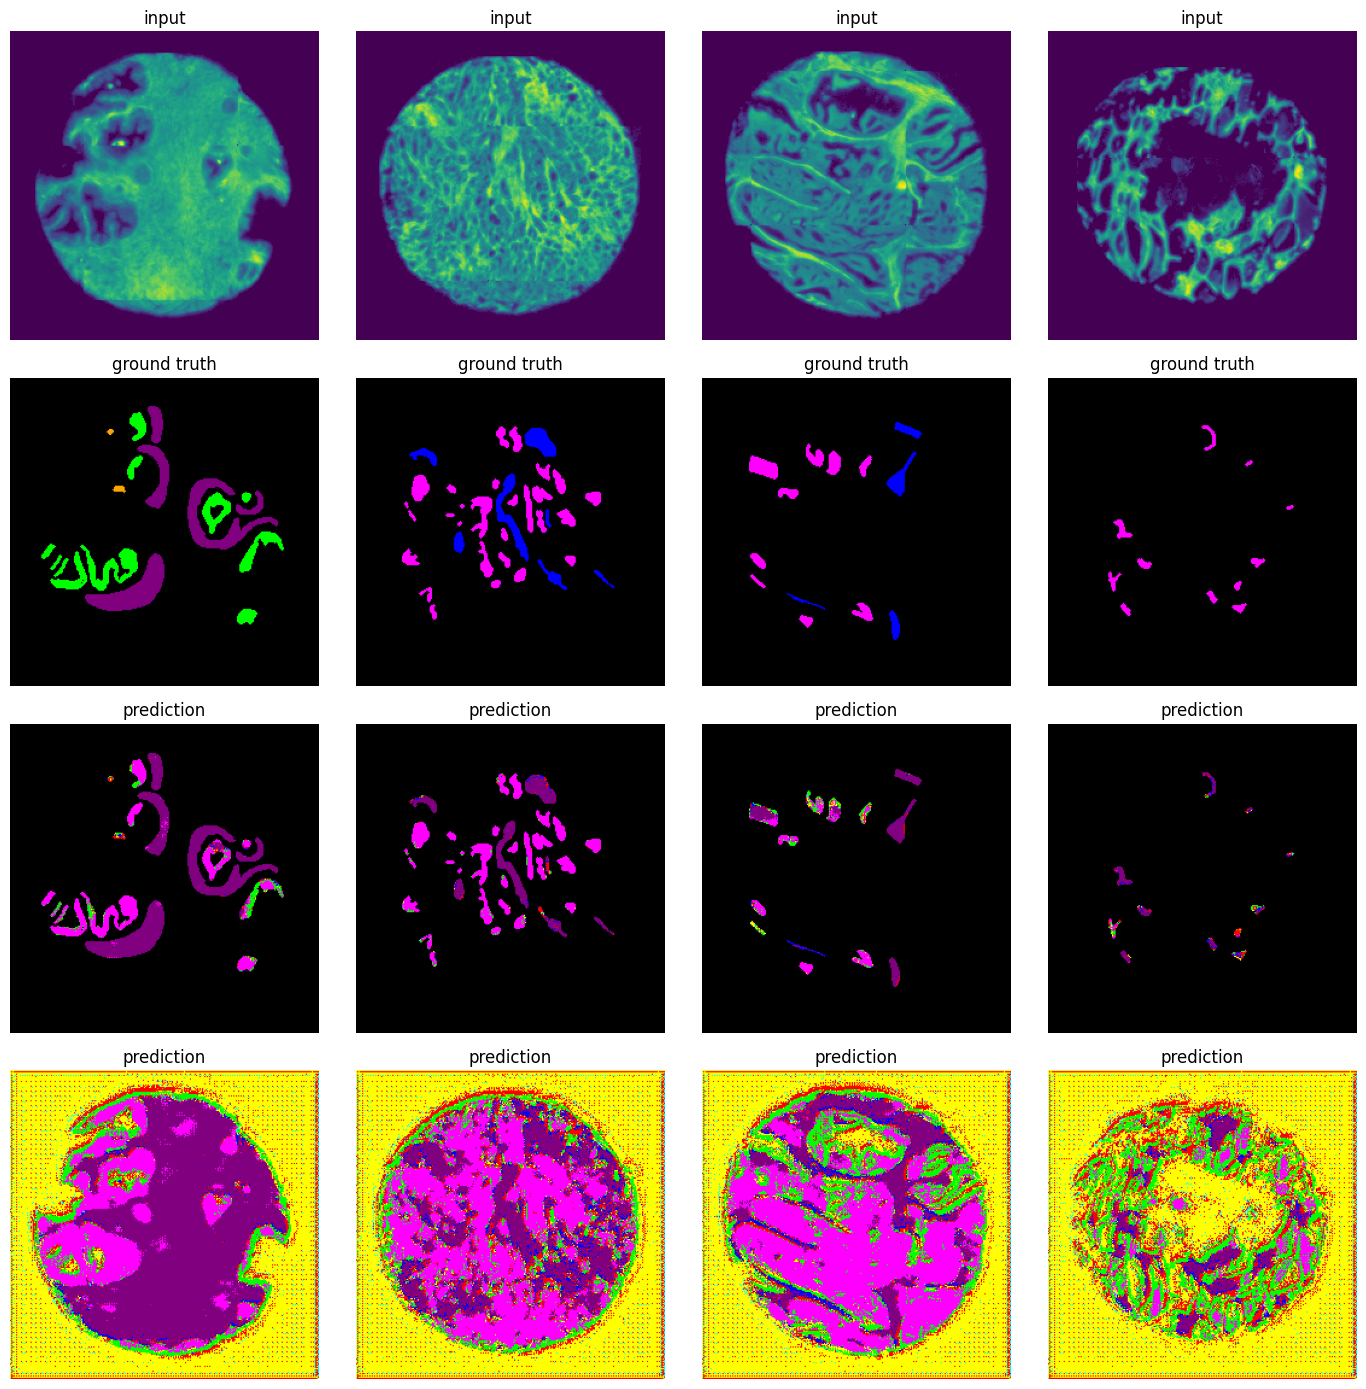

In [79]:
data,annotations = next(iter(train_loader))
out = model(data.to(device)).detach().cpu().numpy() 

mask = annotations.sum(dim=1)!=0
annotmask = annotation_class_colors[annotations.argmax(axis=1)]
predmask = annotation_class_colors[out.argmax(axis=1)]
predmask2 = predmask.copy()
annotmask[mask==0] = 0; predmask[mask==0] = 0

fig,ax = plt.subplots(4,batch_size,figsize=(14,14))
for x in range(batch_size):
    ax[0,x].imshow(data[x,0,:,:].cpu().numpy()); ax[0,x].set_axis_off(); ax[0,x].set_title("input")
    ax[1,x].imshow(annotmask[x]/255); ax[1,x].set_axis_off(); ax[1,x].set_title("ground truth")
    ax[2,x].imshow(predmask[x]/255); ax[2,x].set_axis_off(); ax[2,x].set_title("prediction")
    ax[3,x].imshow(predmask2[x]/255); ax[3,x].set_axis_off(); ax[3,x].set_title("prediction")
fig.tight_layout()
# todo save fig